# How can I compare different models that predict the probability of defaulting on a loan?

## Goal:

In this case, we will conduct a comprehensive walkthrough of a binary classification data science problem. We aim to combine the various pre-modeling techniques we hae learned with **cross-validation** to tune a logistic regression model.

Additionally, we introduce various metrics (ROC/AUC) to evaluate the performance of our classification model which is inherently different from the previous linear regression models we have encountered. This goal may seem a bit daunting or technical but by the end of the case, all these terms should be clear to you.

In [1]:
### Load relevant packages
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import os

from scipy import stats

%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

## Introduction

**Business Context.** Traditional commercial banks typically did not rely on statistical modeling to decide whether personal loans should be issued, although this is changing rapidly nowadays. You are a data scientist working in a modern commercial bank. Your data science team has already built simple regression models for predicting the probability that those loans would be defaulted on. However, you have noticed that many of these models perform much worse in production than they do in testing.

**Business Problem.** Your task is to **build a default probability model that you feel comfortable putting into production**.

**Analytical Context.** The dataset contains the details of 5000 loan requests that have been previously issued by your bank. For each loan, the final status of the loan (i.e. whether the loan defaulted) is also available:

1. The file **"loan_light.csv"** contains the details of 5000 loans
2. The file **"loan_param.xlsx"** contains the description of each covariate

The case will proceed as follows: you will 1) perform some data exploration to determine the appropriate variable transformations to make; 2) fit some simple models; 3) learn about **cross-validation** and use this to select the best simple model; and finally 4) responsibly construct more complex models using cross-validation.

## Data exploration

Let's start by taking a look at the data:

In [2]:
Data = pd.read_csv("loan_light.csv")
Data = Data.sample(frac=1)  #shuffle the rows

In [3]:
Data.head()

,annual_inc,application_type,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,grade,inq_last_12m,installment,...,num_actv_bc_tl,pub_rec_bankruptcies,home_ownership,term,mort_acc,num_tl_90g_dpd_24m,purpose,year,loan_default,job
1975,61910.0,Individual,2186.0,0.0,0.0,25.53,10,B,0.0,1130.51,...,3.0,0.0,OWN,36,0.0,0.0,debt_consolidation,2018,0,principal
3375,73000.0,Individual,11919.0,0.0,5.0,18.00,10,D,5.0,362.97,...,2.0,0.0,RENT,60,2.0,0.0,debt_consolidation,2017,1,specialist
3500,42000.0,Individual,3190.0,0.0,0.0,28.96,10,B,1.0,83.03,...,2.0,0.0,MORTGAGE,36,0.0,0.0,debt_consolidation,2017,0,nurse
1811,76000.0,Individual,9206.0,0.0,0.0,18.90,1,C,1.0,167.85,...,3.0,1.0,RENT,36,0.0,0.0,debt_consolidation,2016,0,specialist
2133,140000.0,Individual,3536.0,0.0,0.0,11.74,10,B,1.0,697.99,...,7.0,0.0,RENT,36,0.0,0.0,debt_consolidation,2017,0,manager


In [4]:
Data.keys()

Index(['annual_inc', 'application_type', 'avg_cur_bal',
       'chargeoff_within_12_mths', 'delinq_2yrs', 'dti', 'emp_length', 'grade',
       'inq_last_12m', 'installment', 'loan_amnt', 'num_actv_bc_tl',
       'pub_rec_bankruptcies', 'home_ownership', 'term', 'mort_acc',
       'num_tl_90g_dpd_24m', 'purpose', 'year', 'loan_default', 'job'],
      dtype='object')

In [5]:
df_description = pd.read_excel('loan_param.xlsx').dropna()
df_description.style.set_properties(subset=['Description'], **{'width': '1000px'})

,BrowseNotesFile,Description
0,loanAmnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
1,annualInc,The self-reported annual income provided by the borrower during registration.
2,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
3,avg_cur_bal,Average current balance of all accounts
4,chargeoff_within_12_mths,Number of charge-offs within 12 months
5,delinq2Yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
6,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
7,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
8,grade,LC assigned loan grade
9,homeOwnership,"The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER."


### Exercise 1:

For each of the following, perform the directed visualization and discuss your conclusions from it.

#### 1.1

Create a [bar chart](https://www.mathsisfun.com/data/bar-graphs.html) showing the number of loans that did and did not default.

**Answer.**

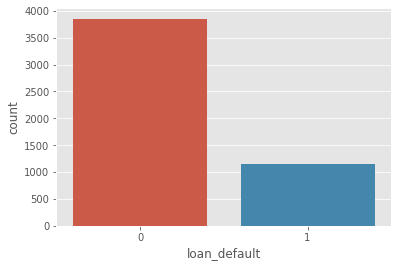

In [8]:
sns.countplot(data = Data, x = "loan_default")

------------

#### 1.2

Plot a [histogram](https://www.mathsisfun.com/data/histograms.html) of the annual incomes.

**Answer.**

Text(0.5, 0, 'Annual Income')

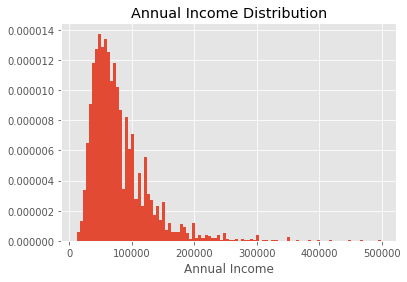

In [12]:

Data.annual_inc.hist(bins=100, density=True)
plt.title("Annual Income Distribution")
plt.xlabel("Annual Income")

------------

We see that the data is quite skewed. Let's try a [logarithmic transformation](https://dev.to/rokaandy/logarithmic-transformation-in-linear-regression-models-why-when-3a7c) to get the data to be more normally distributed:

Text(0.5, 0, 'Annual Income')

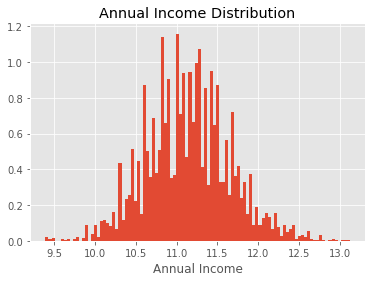

In [8]:
np.log(Data.annual_inc).hist(bins=100, density=True)
plt.title("Annual Income Distribution")
plt.xlabel("Annual Income")

#### 1.3

Is the distribution of annual incomes different between applicants who defaulted vs. applicants who did not default on their loans?

**Answer.**
they are not really different but the non-defaulters distribution meand apparently is a little bit more to the right, which means that non-defaulters earn more that non defaulters and running ttest between them it shows that there is evidence to say that their means are different

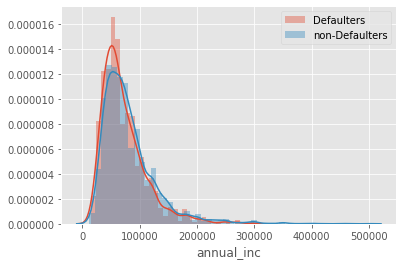

In [28]:
defaulted = Data["loan_default"] == 1

sns.distplot(Data[defaulted]["annual_inc"],label="Defaulters")
sns.distplot(Data[~defaulted]["annual_inc"],label="non-Defaulters")
plt.legend()

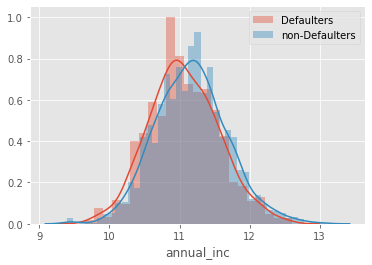

In [48]:

sns.distplot(np.log(Data[defaulted]["annual_inc"]),label="Defaulters")
sns.distplot(np.log(Data[~defaulted]["annual_inc"]),label="non-Defaulters")
plt.legend()

In [32]:
stats.ttest_ind(Data[defaulted]["annual_inc"],Data[~defaulted]["annual_inc"])

Ttest_indResult(statistic=-5.757424309833848, pvalue=9.050571323016807e-09)

------------

#### 1.4

Explore the association between annual income and the monthly installment.

**Answer.**

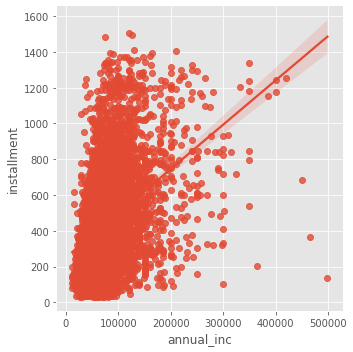

In [38]:
sns.lmplot(data = Data, x="annual_inc",y="installment")

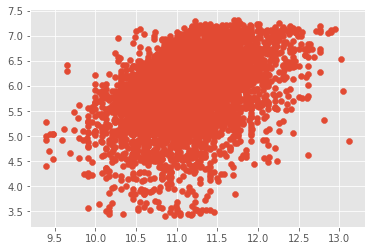

In [40]:
plt.scatter(np.log(Data.annual_inc),np.log(Data.installment))

------------

Here are a few more figures which look at the relationship between other numerical covariates and the probability of default, as well as annual income:

`emp_length`:

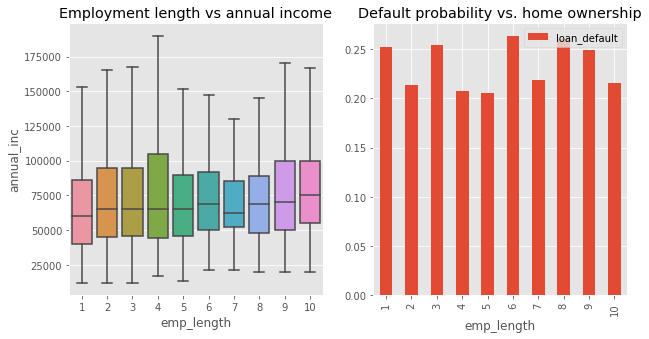

In [43]:
fig, (ax1, ax2) = plt.subplots(figsize = (10,5), ncols=2, sharey= False)
sns.boxplot(x='emp_length', y = 'annual_inc', data = Data, showfliers=False, ax = ax1) #showfliers=False for nice display
ax1.set_title("Employment length vs annual income")
Data[["emp_length",'loan_default']].groupby("emp_length").mean().plot.bar(rot=90,ax = ax2)
plt.title("Default probability vs. home ownership");

`homeOwnership`:

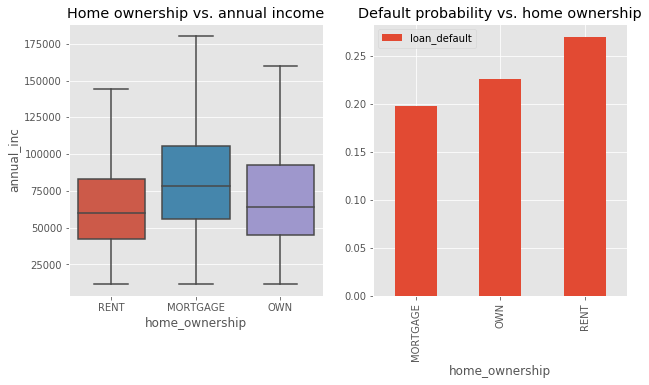

In [10]:
fig, (ax1, ax2) = plt.subplots(figsize = (10,5), ncols=2, sharey= False)
sns.boxplot(x="home_ownership",y="annual_inc", data = Data, showfliers=False, ax = ax1) #showfliers=False for nice display
ax1.set_title("Home ownership vs. annual income")
Data[["home_ownership",'loan_default']].groupby("home_ownership").mean().plot.bar(rot=90,ax = ax2)
plt.title("Default probability vs. home ownership");

Here are some figures that show the relationship between various categorical variables and the probability of default:

`purpose`:

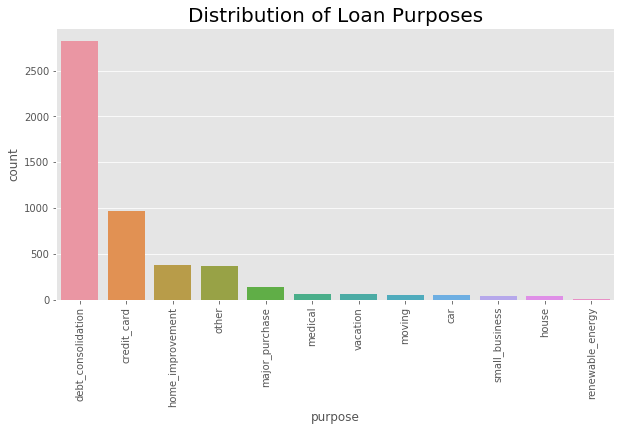

In [11]:
plt.figure(figsize= (10,5))
Data.emp_length.value_counts()
sns.countplot(x='purpose', order=Data['purpose'].value_counts().index, data = Data) 
plt.xticks(rotation=90)
plt.title("Distribution of Loan Purposes", fontsize=20);

Text(0.5, 1.0, 'Default Probability by Loan Purpose')

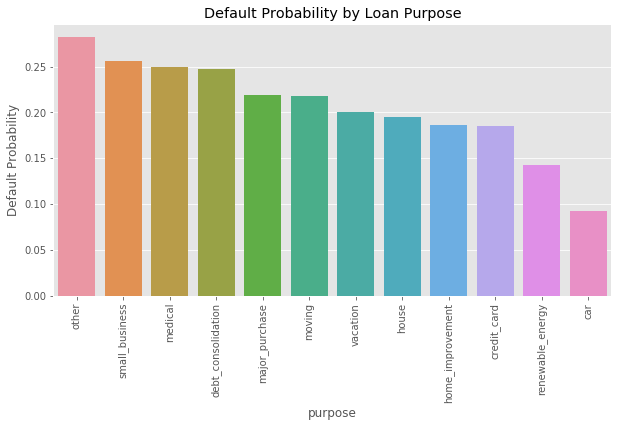

In [54]:
plt.figure(figsize= (10,5))
purpose_default = Data[["loan_default", "purpose"]].groupby("purpose").mean()
purpose_default

purpose_default = purpose_default.sort_values(by="loan_default",axis=0, ascending=False)


sns.barplot(x=purpose_default.index[:30], 
            y=purpose_default["loan_default"][:30].values,
            orient="v")
plt.xticks(rotation=90)
plt.ylabel("Default Probability");
plt.title("Default Probability by Loan Purpose")

`job`:

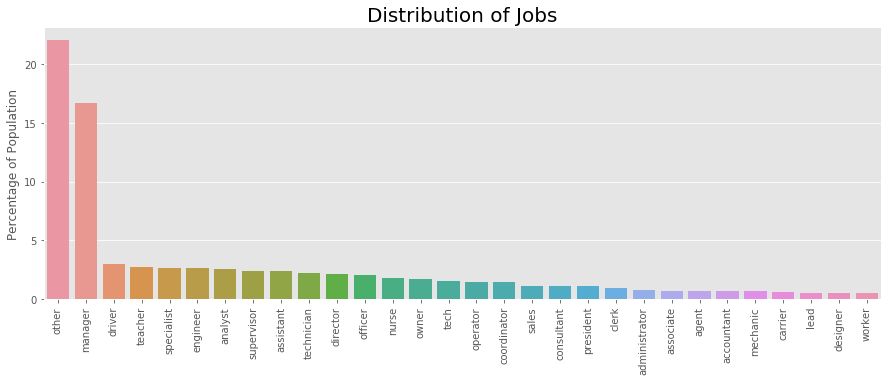

In [13]:
plt.figure(figsize= (15,5))
sns.barplot(x=Data["job"].value_counts()[:30].index.values , 
            y=100 * Data.job.value_counts()[:30].values / len(Data),
            orient="v")
plt.xticks(rotation=90)
plt.ylabel("Percentage of Population")
plt.title("Distribution of Jobs", fontsize=20);


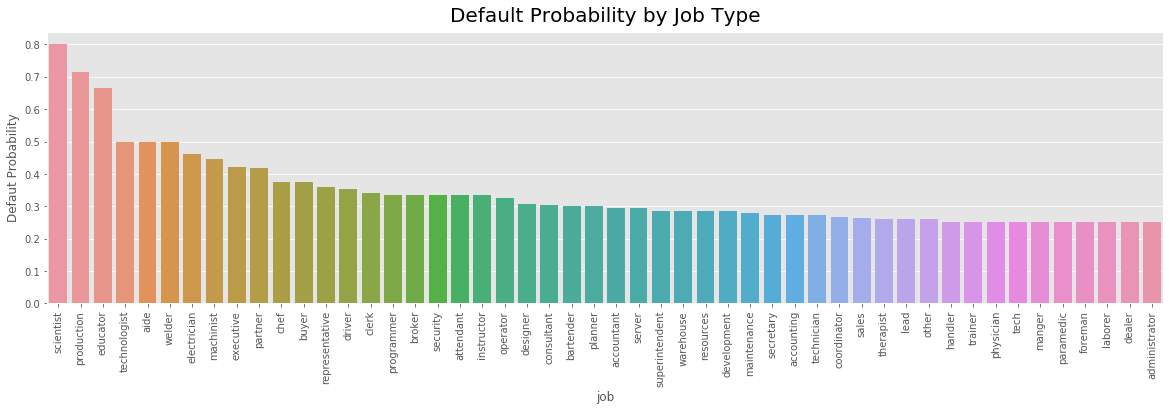

In [14]:
plt.figure(figsize= (20,5))

df_job_default = Data[["loan_default", "job"]].groupby("job").mean()
df_job_default = df_job_default.sort_values(by="loan_default",axis=0, ascending=False)
sns.barplot(x=df_job_default.index[:50], 
            y=df_job_default["loan_default"][:50].values,
            orient="v")
plt.xticks(rotation=90)

plt.ylabel("Defaut Probability")
plt.title("Default Probability by Job Type", fontsize=20, verticalalignment='bottom');

### Adding a new variable

The yearly payment owed by the borrower, as a fraction of their annual income, is a standard metric used in evaluating whether a loan should be issued. Let's define a new variable **"install_income"** which codes the installment as a fraction of the annual income and study its association with the other features:

Text(0.5, 0, 'Installment / Income')

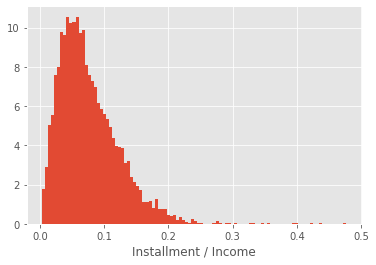

In [15]:
Data['install_income'] = 12 * Data.installment / Data.annual_inc
H = plt.hist(Data['install_income'], bins=100, density=True)
plt.xlabel(r"Installment / Income")

In order to easily investigate this variable's association with the probability of default, define a new covariate named `install_income_disc` that is a discretized version of `install_income`:

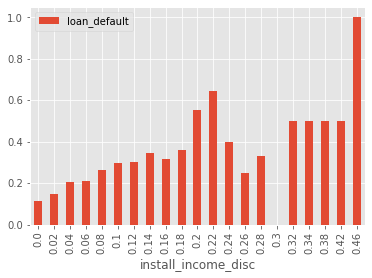

In [16]:
# let us discretize the "install_income" variable to study the probability of default 
# as a function of "install_income"
Data["install_income_disc"] = (Data.install_income*50).astype(int)/50.  #discretization
Data[["loan_default", "install_income_disc"]].groupby("install_income_disc").mean().plot.bar(rot=90)
Data = Data.drop(["install_income_disc"], axis=1)

# --> there is a clear positive association: as the fraction of the annual income devoted to the re-imbursement of 
# the loan increases, the probability of default sharply increases

### Exercise 2:

Visualize the [correlation matrix](https://www.statisticshowto.com/correlation-matrix/) across all numerical features by using the `sns.heatmap()` command:

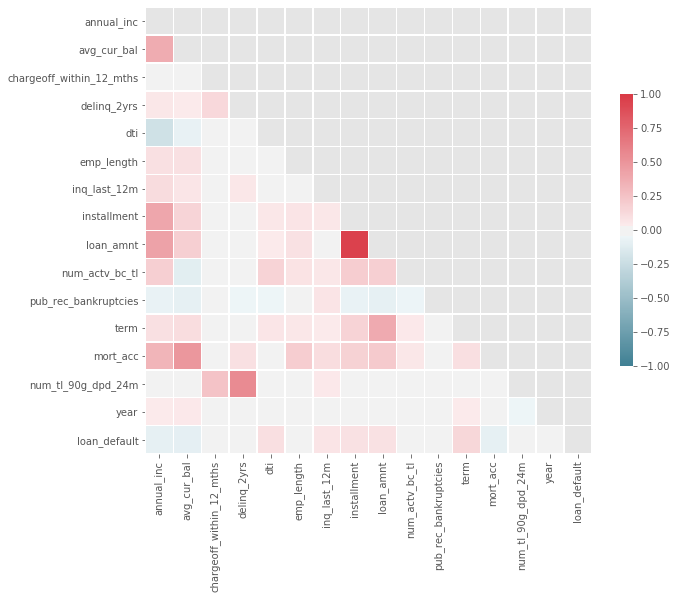

In [74]:
#compute correlation matrix
df_correlations = Data.corr()

#mask the upper half for visualization purposes
mask = np.zeros_like(df_correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize= (10,10))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_correlations,mask=mask,  vmax=1, vmin=-1, cmap=cmap, 
            center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

We can see here that `installment` and `loan_amnt` are highly correlated. In general, we can use a correlation matrix as an early feature selection technique to remove features that are extremely correlated to account for multicollinearity. There is no scientific cutoff for when a correlation warrants removing a feature so always investigate further. Think of it as a red flag moment when you see highly correlated parameters and then investigate the reason behind such a correlation to see if one of the features can be removed. A classic example of correlated features that require removal would be two features displaying distance in miles and kilometers, respectively. There is clearly redundant information there.

## Building a predictive model

Let's first start by building a standard [logistic regression model](https://www.youtube.com/watch?v=yIYKR4sgzI8). In general, it is important and extremely useful to first create baseline/simple models which can be compared to more complex models later.

### Exercise 3:

#### 3.1

Using the `LogisticRegression()` function from `scikit-learn`, write a function named `fit_logistic_regression(X,y)` that fits a logistic regression on the array of covariates `X` and associated response variable `y`.

**Answer.**

In [18]:
from sklearn.linear_model import LogisticRegression
def fit_logistic_regression(X,y):
    """
    fit a logistic regression with feature matrix X and binary output y
    """
    clf = LogisticRegression(solver='lbfgs', tol=10**-4,  
                             fit_intercept=True, 
                             multi_class='multinomial').fit(X,y)
    return clf

------------

#### 3.2

Create a basic [logistic regression model](https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc) for predicting the loan default with only one feature: `install_income`.  Call this model `model1`. Use a 70/30 train-test split of the data.

**Answer.**

In [22]:
Data.head()

,annual_inc,application_type,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,grade,inq_last_12m,installment,...,pub_rec_bankruptcies,home_ownership,term,mort_acc,num_tl_90g_dpd_24m,purpose,year,loan_default,job,install_income
3316,51500.0,Individual,13864.0,0.0,0.0,20.60,2,C,0.0,202.26,...,0.0,RENT,36,0.0,0.0,debt_consolidation,2017,1,teacher,0.047129
779,48000.0,Individual,10267.0,0.0,0.0,34.15,7,D,4.0,722.95,...,0.0,MORTGAGE,36,2.0,0.0,debt_consolidation,2016,0,manager,0.180738
916,63600.0,Individual,28891.0,0.0,0.0,21.11,5,B,1.0,255.04,...,0.0,MORTGAGE,36,6.0,0.0,debt_consolidation,2016,0,manager,0.048121
4182,60000.0,Individual,6882.0,0.0,1.0,21.98,9,C,2.0,236.30,...,1.0,MORTGAGE,60,4.0,0.0,debt_consolidation,2016,1,worker,0.047260
1613,85000.0,Joint App,21065.0,0.0,0.0,12.42,4,C,1.0,1210.72,...,0.0,MORTGAGE,36,7.0,0.0,debt_consolidation,2016,0,examiner,0.170925


In [23]:
np.random.seed(0)

dataLen = len(Data)
xsize = int(dataLen*0.7)
X_ind = np.random.choice(range(dataLen),xsize,replace=False)
X_ind
X_train = Data.iloc[X_ind]["install_income"]
Y_train = Data.iloc[X_ind]["loan_default"]

X_test_ind = 

X

3258    0.096662
1139    0.052747
3300    0.049367
330     0.050313
3245    0.027582
          ...   
2180    0.066981
634     0.051069
4339    0.073452
3674    0.216886
1576    0.031389
Name: install_income, Length: 3500, dtype: float64

------------

Now that we have fitted a model, we will proceed to evaluate how "good" it is. Classification models are judged differently than linear regression models. A common tool you will have to get used to is the [confusion matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62). Additionally, we will introduce some other metrics related to classification algorithms below. It is important to note these metrics apply to other classification models, not just logistic regression.

#### 3.3

Plot the [ROC curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) of `model1` and find the area under the curve.

**Answer.**

------------

### Exercise 4:

#### 4.1

Consider `model1` from above. Would you want this to be your final model? Why or why not?

**Answer.**

------------

#### 4.2

Let's instead put all the variables available in the model, so that we are maximally leveraging our available info. Would you be in favor of this or not?

**Answer.**

------------

In most cases, you will be working with datasets with many features that each have their own distribution. Generally, a large amount of time is spent on feature selection with many models being trained during this time. It is extremely rare that you simply plug all the features in and tune it once to get the optimal model. 
    
There are many different techniques associated with feature selection and a comprehensive look into all of them is outside the scope of this case. For simplicity, we will demonstrate model training and testing on single-feature models and then directly move into multi-feature models to show the numerous possible cases you may encounter. In reality, we would apply cross-validation on numerous subsets of features based on domain knowledge of the dataset to see which set of features truly optimizes the model we are trying to create.

## Cross-validation

[**Cross-validation**](https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f) is a set of techniques for assessing how well the results of a model will generalize to an out-of-sample dataset; i.e. in practice or production. It is chiefly used to flag overfitting.

Cross-validation works as follows: one splits the available data into $k$ sets, or **folds**. $k - 1$ of these folds will be used to train the model, while the held-out fold will be used as the test set on which the model is evaluated. For computational stability, this procedure is generally split many times, such that each fold has an opportunity to serve as the test set. For each repetition, a metric of prediction performance (e.g. AUC) is calculated on the test set. The average of these metrics, as well as their standard deviation, is then reported. 

There is no exact science for choosing a proper $k$ for your dataset. It depends on what type of data you are using and how large it is. The larger $k$ is, the most iterations you run which lowers the chance you get "unlucky"; however, running more iterations can be costly in some cases. Additionally, it is important to make sure no matter what $k$ you choose that the validation set is still large enough to be meaningful. If you have a data set of 100 points and choose a $k$ of 20, then the validation set will only be 5 points. It is likely some iterations will perform poorly simply because the validation set is too small and potentially too different from the training set.

An example is shown here for 5-fold cross-validation:

![](cv_fig.png)

Let's do this with code. The following code displays the 5 different folds used in a standard 5-fold cross-validation approach. To do so, use the `StratifiedKFold()` function from `scikit-learn`:

In [ ]:
skf = StratifiedKFold(n_splits=5)
for k, (train_index, test_index) in enumerate( skf.split(X, y) ):
    plt.plot(train_index, [k+1 for _ in train_index], ".")
plt.ylim(0,6)
plt.ylabel("FOLD")
plt.title("CROSS VALIDATION FOLDS")

The following code defines a function `compute_AUC(X, y, train_index, test_index)` that computes the AUC of a model trained on "train_index" and tested in "test_index".

In [ ]:
def compute_AUC(X, y, train_index, test_index):
    """
    feature/output: X, y
    dataset split: train_index, test_index
    """
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    clf = fit_logistic_regression(X_train, y_train)
    default_proba_test = clf.predict_proba(X_test)[:,1]  
    fpr, tpr, _ = roc_curve(y_test, default_proba_test)
    auc_score = auc(fpr, tpr)
    return auc_score, fpr, tpr

### Exercise 5:

With the help of the `compute_AUC` function defined above, write a function `cross_validation_AUC(X,y,nfold)` that carries out a 10-fold cross-validation and returns a list which contains the area under the curve for each fold of the cross-validation.

**Answer.**

------------

We will now estimate and compare, through cross-validation analysis, the performance of all the "simple models" that only use one numerical feature as input. As discussed in the EDA section, we will use the logarithmic transform for the `anual_income`, `loan_amount`, and `avg_cur_bal` variables:

In [ ]:
# let us extract only the numerical (i.e non-categorical) features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
Data_numerics = Data.select_dtypes(include=numerics)
Data_numerics = Data_numerics.drop(["installment", "year"], axis=1)

# Using a log scale when appropriate
Data_numerics["annual_inc"] = np.log10(Data_numerics["annual_inc"])
Data_numerics["loan_amnt"] = np.log10(Data_numerics["loan_amnt"])
Data_numerics["avg_cur_bal"] = np.log10(1.+Data_numerics["avg_cur_bal"])

Let's compute cross-validation estimates of the AUC for each single-feature model:

In [ ]:
model_perf = pd.DataFrame({}) #this data-frame will contain the AUC estimates
for key in Data_numerics.keys():
    if key == "loan_default": continue
    X_full, y_full = Data_numerics[[key]], Data_numerics.loan_default
    auc_list = cross_validation_AUC(X_full, y_full, nfold=10)
    model_perf["SIMPLE:" + key] = auc_list

### Exercise 6:

Construct a [boxplot](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51) which shows the distribution of cross-validation scores of each variable (remember, each variable has 10 total scores). Which feature has the highest/lowest predictive power?

**Answer.**

------------

### Exercise 7:

Consider the model that consists of using *all* the numerical features (and none of the categorical features). Carry out a 10-fold cross-validation analysis to determine whether this model has better predictive performance than the best single-feature model. Use the boxplot method again as we did in Exercise 7.

**Answer.**

------------

## Incorporating categorical variables

The grade of a loan (i.e. the LC-assigned loan grade feature) has not been used so far. The following is the distribution of the categorical grade feature:

In [ ]:
Data.emp_length.value_counts()
sns.countplot(x='grade', data = Data) 
plt.xticks(rotation=90)

### Exercise 8:

#### 8.1

Use `pandas.get_dummies()` to transform this into its one-hot encoded version.

**Answer.**

------------

#### 8.2

Add this feature to the all-numerical model from earlier and investigate whether this leads to a significant increase in predictive accuracy.

**Answer.**

------------

### Exercise 9:

Investigate whether the categorical variable `job` brings any predictive value when added to the current best model. Again, you may want to use a one-hot encoding scheme.

**Answer.**

------------

## Conclusions

In this case, we first explored the loan dataset and found the single-variable associations between the available features and the default rate. We also discovered which features required transformations (e.g. log transform).

Once we started building models, we started with very simple logistic regressions approaches – these baseline models were useful for quickly evaluating the predictive power of each individual variable. Next, we employed cross-validation approaches for building more complex models, often exploiting the interactions between the different features. Since the loan dataset contains a large number of covariates, using cross-validation was revealed to be crucial for avoiding overfitting, choosing the correct number of features and ultimately choosing an appropriate model that balanced complexity with accuracy.

## Takeaways

Cross-validation is a robust and flexible technique for evaluating the predictive performance of statistical models. It is especially useful in big data settings where the number of features is large compared to the number of observations. When used appropriately, cross-validation is a powerful method for choosing a model with the correct complexity and best predictive performance. Remember that logistic regression is only one of many classification algorithms and the principles behind cross-validation are not limited to this case alone. In fact, we highly recommend utilizing cross-validation for your linear regression models as well to prevent overfitting.